In [1]:
## load our libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

import catboost
from sklearn import preprocessing 


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score

### 1) Data Preparation

In [2]:
#lets load both our train and test datasets .
# additionally , lets also load our variable definition file

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
vardef = pd.read_csv('VariableDefinitions.csv')

# lets create a copy for both the train and test dataset 
trainCopy = train.copy()
testCopy = test.copy()


# lets have a look at our variable definition 
vardef

,ID,Person unique/random identification
0,country_code,The country codes
1,region,"Region_codes of a given country,.i.e., South A..."
2,age,Individual age
3,FQ1,Has ATM/debit card
4,FQ2,Is the ATM connected to an account with your n...
5,FQ3,Purchased with the ATM
6,FQ4,Has a credit card
7,FQ5,Used the credit card in 12 months
8,FQ6,Money deposits to a bank account in the last 1...
9,FQ7,Money withdrawals from a bank account in the l...


In [3]:
train.head()

,ID,country_code,region,age,FQ1,FQ2,FQ3,FQ4,FQ5,FQ6,...,FQ27,FQ28,FQ29,FQ30,FQ31,FQ32,FQ33,FQ34,FQ37,Target
0,ID_000J8GTZ,1,6,35.0,2,NaN,NaN,2,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0,0
1,ID_000QLXZM,32,7,70.0,2,NaN,NaN,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,1.0,2.0,0,0
2,ID_001728I2,71,7,22.0,2,1.0,NaN,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,1.0,1,0
3,ID_001R7IDN,48,3,27.0,1,NaN,NaN,2,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,2.0,1.0,1.0,1,0
4,ID_0029QKF8,25,0,79.0,2,NaN,NaN,2,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,2.0,1.0,1.0,1,0


In [4]:
## performing feature preparation
# our df does not have null values 
null_value_stats = train.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

age        322
FQ2      59322
FQ3      62228
FQ5      87261
FQ6      47787
FQ7      47826
FQ11     24570
FQ17     97099
FQ19     47407
FQ20     24679
FQ21     24635
FQ24     70014
FQ35     82557
FQ36     96963
FQ27    105246
FQ28    106940
FQ29     24534
FQ30    106331
FQ31    107577
FQ32     47650
FQ33         2
FQ34     31794
dtype: int64

In [6]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (154923, 42)


In [7]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154923 entries, 0 to 154922
Data columns (total 42 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            154923 non-null  object 
 1   country_code  154923 non-null  int64  
 2   region        154923 non-null  int64  
 3   age           154472 non-null  float64
 4   FQ1           154923 non-null  int64  
 5   FQ2           69925 non-null   float64
 6   FQ3           66146 non-null   float64
 7   FQ4           154923 non-null  int64  
 8   FQ5           30098 non-null   float64
 9   FQ6           86537 non-null   float64
 10  FQ7           86537 non-null   float64
 11  FQ8           154923 non-null  int64  
 12  FQ9           154923 non-null  int64  
 13  FQ10          154923 non-null  int64  
 14  FQ11          119788 non-null  float64
 15  FQ12          154923 non-null  int64  
 16  FQ13          154923 non-null  int64  
 17  FQ14          154923 non-null  int64  
 18  FQ15

In [8]:
all_data.isnull().sum()

ID                   0
country_code         0
region               0
age                451
FQ1                  0
FQ2              84998
FQ3              88777
FQ4                  0
FQ5             124825
FQ6              68386
FQ7              68386
FQ8                  0
FQ9                  0
FQ10                 0
FQ11             35135
FQ12                 0
FQ13                 0
FQ14                 0
FQ15                 0
FQ16                 0
FQ17            138698
FQ18                 0
FQ19             67764
FQ20             35135
FQ21             35135
FQ22                 0
FQ23                 0
FQ24             99926
FQ35            117982
FQ36            138540
FQ25                 0
FQ26                 0
FQ27            150280
FQ28            152786
FQ29             35135
FQ30            151932
FQ31            153690
FQ32             68127
FQ33                 2
FQ34             45135
FQ37                 0
Target           46477
dtype: int64

In [10]:
# Fill in missing values
for col in all_data.columns:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(all_data[col].fillna(0))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum().any()

False

In [12]:
# Shape of data before encoding
all_data.shape

(154923, 42)

In [13]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((108446, 42), (46477, 42))

In [14]:
train_df.columns

Index(['ID', 'country_code', 'region', 'age', 'FQ1', 'FQ2', 'FQ3', 'FQ4',
       'FQ5', 'FQ6', 'FQ7', 'FQ8', 'FQ9', 'FQ10', 'FQ11', 'FQ12', 'FQ13',
       'FQ14', 'FQ15', 'FQ16', 'FQ17', 'FQ18', 'FQ19', 'FQ20', 'FQ21', 'FQ22',
       'FQ23', 'FQ24', 'FQ35', 'FQ36', 'FQ25', 'FQ26', 'FQ27', 'FQ28', 'FQ29',
       'FQ30', 'FQ31', 'FQ32', 'FQ33', 'FQ34', 'FQ37', 'Target'],
      dtype='object')

In [15]:
trainId = train_df['ID']
testId =test_df['ID']
X= train_df.drop(['Target','ID'],axis=1)
y= train_df['Target']

test_df = test_df.drop('ID',axis=1)

In [16]:
# cat_features
cat_features = ['country_code','region']
cat_features = X[cat_features]


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_df

In [19]:
from catboost import CatBoostClassifier, Pool, metrics, cv
# Model Training 
model = CatBoostClassifier(
   custom_loss=['Logloss','AUC','Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
cv_params = model.get_params()
print(cv_params)

{'random_seed': 42, 'logging_level': 'Silent', 'custom_loss': ['Logloss', 'AUC', 'Accuracy']}


In [21]:
## attempting cross-validation

cv_params.update({'loss_function': metrics.Logloss() })

cv_data = cv(
    Pool(X, y, cat_features=cat_features),
    cv_params,
    nfold = 5,
    iterations= 1200,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [22]:
print('Best validation AUC score is: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-AUC-mean']),
    cv_data['test-AUC-std'][np.argmax(cv_data['test-AUC-mean'])],
    np.argmax(cv_data['test-AUC-mean'])
))

Best validation AUC score is: 0.51±0.00 on step 4


In [23]:
print('Precise  AUC score: {}'.format(np.max(cv_data['test-AUC-mean'])))

Precise  AUC score: 0.5051431760307888


In [24]:
# Model applying 
predictions = model.predict(X_test)
predictions_probs = model.predict_proba(X_test)[:, 1]
print(predictions_probs[:10])

[0.28923255 0.27971158 0.2824904  0.28112794 0.28125496 0.27982452
 0.28445    0.28235806 0.28162452 0.2799856 ]


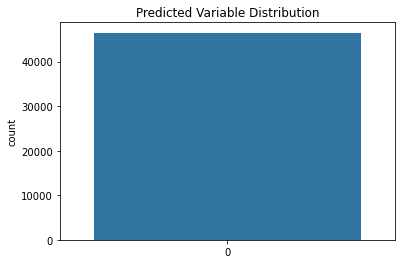

In [28]:
# # Create a submission file
samplesubmission = pd.read_csv('SampleSubmission.csv')
sub_file = samplesubmission.copy()
sub_file.Target = predictions_probs

# # Check the distribution of your predictions
sns.countplot([1 if x >= 0.5 else 0 for x in sub_file.Target])
plt.title('Predicted Variable Distribution');

In [29]:
# Create a csv file and upload to zindi 

sub_file.to_csv('Baseline.csv', index = False)
sub_file.head()

,ID,Target
0,ID_000YI58E,0.289233
1,ID_001SP4JF,0.279712
2,ID_001VOF6S,0.282490
3,ID_0030LULG,0.281128
4,ID_0037PZ3R,0.281255


In [30]:
## catboost features 

params = {
    'iterations': 2000,
    'learning_rate': 0.15,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(X_train, y_train, cat_features=cat_features)
validate_pool = Pool(X_validation, y_validation, cat_features=cat_features)

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)


best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);


print('Simple model validation accuracy: {:.4}'.format(accuracy_score(y_validation, model.predict(X_validation))))
print('')

print('Best model validation accuracy: {:.4}'.format( accuracy_score(y_validation, best_model.predict(X_validation))))

Simple model validation accuracy: 0.7136

Best model validation accuracy: 0.7176


In [31]:
predictions = best_model.predict_proba(X_test)[:, 1]
sub_file.target = predictions

# Create a csv file and upload to zindi 

sub_file.to_csv('Baseline.csv', index = False)
sub_file.head()

,ID,Target
0,ID_000YI58E,0.289233
1,ID_001SP4JF,0.279712
2,ID_001VOF6S,0.282490
3,ID_0030LULG,0.281128
4,ID_0037PZ3R,0.281255


In [ ]:
## Has a score of 0.50234 AUC on zindi